In [ ]:
# === LIMPIEZA Y VALIDACIÓN SIMA 2022 (todas las estaciones) ===
# Requiere: pandas >= 1.3

import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------------------------------------------------
# 0) CONFIG
# --------------------------------------------------------------------
file_path = "DATOS HISTÓRICOS 2022_2023_TODAS ESTACIONES.xlsx"  # <-- ajusta si es necesario
out_unificado_csv = "sima_2022_unificado.csv"
out_limpio_csv     = "sima_2022_limpio.csv"
out_reporte_csv    = "sima_2022_reporte_calidad.csv"

# Rangos de operación para **2022** (de tu tabla)
# Nota: las llaves deben coincidir con las columnas después de estandarizar (minúsculas, guiones bajos).
RANGOS_2022 = {
    "pm10":   (0, 999),
    "pm2_5":  (0, 450),
    "o3":     (0, 160),
    "no":     (0, 400),
    "no2":    (0, 175),
    "nox":    (0, 420),
    "so2":    (0, 200),
    "co":     (0, 8),
    "rh":     (0, 100),     # %
    "wsr":    (0, 35),      # km/h (WS en tu tabla; aquí la columna suele llamarse WSR)
    "tout":   (-5, 45),     # °C
    "sr":     (0, 1.25),    # kW/m2
    "prs":    (700, 740),   # mmHg
    "wdr":    (0, 360),     # grados
    "rainf":  (0, 25),      # mm/h
}

# --------------------------------------------------------------------
# 1) Cargar libro y unificar hojas (excepto 'CATÁLOGO')
# --------------------------------------------------------------------
xls = pd.ExcelFile(file_path)
sheet_names = [s for s in xls.sheet_names if s.strip().upper() != "CATÁLOGO"]

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
                  .str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace(r"[^\w]+", "_", regex=True)
    )
    return df

frames = []
for s in sheet_names:
    df_s = pd.read_excel(xls, sheet_name=s)
    df_s["__sheet"] = s  # estación/origen
    frames.append(df_s)

df_all = pd.concat(frames, ignore_index=True, sort=False)
df_all = standardize_columns(df_all)

# --------------------------------------------------------------------
# 2) Detectar columna datetime y generar año/mes/día/hora
# --------------------------------------------------------------------
datetime_candidates = [c for c in df_all.columns if any(k in c for k in ["fecha", "hora", "time", "date"])]
dt_col = None
for c in datetime_candidates:
    try:
        test = pd.to_datetime(df_all[c], errors="coerce")
        if test.notna().mean() > 0.3:
            dt_col = c
            break
    except Exception:
        pass

if dt_col is None:
    raise RuntimeError("No se detectó columna de fecha/hora. Revisa nombres de columnas.")

df_all[dt_col] = pd.to_datetime(df_all[dt_col], errors="coerce")
df_all["year"]  = df_all[dt_col].dt.year
df_all["month"] = df_all[dt_col].dt.month
df_all["day"]   = df_all[dt_col].dt.day
df_all["hour"]  = df_all[dt_col].dt.hour

# --------------------------------------------------------------------
# 3) Filtrar solo 2022 y estandarizar nombre de estación
# --------------------------------------------------------------------
df_2022 = df_all[df_all["year"] == 2022].copy()
df_2022.rename(columns={"__sheet": "estacion"}, inplace=True)

# --------------------------------------------------------------------
# 4) Quitar duplicados por (estación, fecha/hora)
# --------------------------------------------------------------------
before_dups = len(df_2022)
df_2022 = df_2022.drop_duplicates(subset=["estacion", dt_col])
after_dups = len(df_2022)
duplicados_removidos = before_dups - after_dups

# Guardar unificado sin limpiar (opcional, útil para auditoría)
df_2022.to_csv(out_unificado_csv, index=False)

# --------------------------------------------------------------------
# 5) Validación con rangos 2022 (fuera de rango -> NaN)
#    Además creamos columnas booleanas *_oor (out-of-range) para auditar.
# --------------------------------------------------------------------
def aplicar_rangos(df: pd.DataFrame, rangos: dict, dt_column: str) -> pd.DataFrame:
    df = df.copy()
    oor_cols = []  # para llevar el registro de columnas auxiliares

    for col, (lo, hi) in rangos.items():
        if col in df.columns:
            # bandera de fuera de rango (True si está fuera de [lo, hi])
            oor_col = f"{col}__oor"
            oor = (df[col].notna()) & ((df[col] < lo) | (df[col] > hi))
            df[oor_col] = oor
            oor_cols.append(oor_col)
            # cualquier valor fuera de rango se invalida
            df.loc[oor, col] = np.nan

    # opcional: asegurar que wdr (dirección del viento) esté en [0,360]
    # si llega a 361 por cierre de rango, lo traemos a 360
    if "wdr" in df.columns:
        df.loc[df["wdr"] > 360, "wdr"] = 360
        df.loc[df["wdr"] < 0, "wdr"] = np.nan

    return df, oor_cols

df_clean, oor_cols = aplicar_rangos(df_2022, RANGOS_2022, dt_col)

# --------------------------------------------------------------------
# 6) Reporte de calidad por variable
# --------------------------------------------------------------------
variables_numericas = [
    c for c in RANGOS_2022.keys() if c in df_clean.columns
]

def reporte_calidad(df: pd.DataFrame, vars_num: list, oor_cols: list) -> pd.DataFrame:
    rows = []
    for v in vars_num:
        n_obs = df[v].notna().sum() + df[v].isna().sum()  # total filas (incluye NaN)
        fuera = df[f"{v}__oor"].sum() if f"{v}__oor" in df.columns else 0
        pct_fuera = 100 * (fuera / len(df)) if len(df) else 0.0
        pct_nulos_post = 100 * df[v].isna().mean()
        rows.append({
            "variable": v,
            "n_filas": len(df),
            "fuera_rango": int(fuera),
            "%_fuera_rango": round(pct_fuera, 2),
            "%_nulos_post": round(pct_nulos_post, 2),
            "min_obs": np.nanmin(df[v].values) if np.any(~np.isnan(df[v].values)) else np.nan,
            "p50_obs": np.nanpercentile(df[v].values, 50) if np.any(~np.isnan(df[v].values)) else np.nan,
            "max_obs": np.nanmax(df[v].values) if np.any(~np.isnan(df[v].values)) else np.nan,
        })
    rep = pd.DataFrame(rows).sort_values("%_fuera_rango", ascending=False, ignore_index=True)
    return rep

reporte = reporte_calidad(df_clean, variables_numericas, oor_cols)

# --------------------------------------------------------------------
# 7) Guardar resultados
# --------------------------------------------------------------------
df_clean.to_csv(out_limpio_csv, index=False)
reporte.to_csv(out_reporte_csv, index=False)

# --------------------------------------------------------------------
# 8) Impresión breve de control
# --------------------------------------------------------------------
print("=== Unificación 2022 ===")
print(f"Filas (antes de quitar duplicados): {before_dups:,}")
print(f"Duplicados removidos: {duplicados_removidos:,}")
print(f"Filas finales: {after_dups:,}\n")

print("=== Vista previa limpio ===")
print(df_clean.head())

print("\n=== REPORTE DE CALIDAD (post-limpieza) ===")
print(reporte)
print(f"\nCSV unificado: {Path(out_unificado_csv).resolve()}")
print(f"CSV limpio:    {Path(out_limpio_csv).resolve()}")
print(f"Reporte:        {Path(out_reporte_csv).resolve()}")


=== Unificación 2022 ===
Filas (antes de quitar duplicados): 123,383
Duplicados removidos: 0
Filas finales: 123,383

=== Vista previa limpio ===
                 date    co    no   no2   nox   o3   pm10   pm2_5    prs  \
0 2022-01-01 00:00:00  2.36  19.8  48.4  68.0  5.0  142.0  111.00  715.7   
1 2022-01-01 01:00:00  2.29  10.8  44.5  55.1  6.0  168.0  112.16  715.5   
2 2022-01-01 02:00:00  2.71  28.3  47.1  75.2  4.0  203.0  139.31  715.4   
3 2022-01-01 03:00:00  2.31  19.6  42.1  61.5  5.0  262.0  177.68  715.1   
4 2022-01-01 04:00:00  1.85  13.0  39.5  52.5  4.0  185.0  134.21  715.1   

   rainf  ...  nox__oor  so2__oor  co__oor  rh__oor  wsr__oor  tout__oor  \
0    0.0  ...     False     False    False    False     False      False   
1    0.0  ...     False     False    False    False     False      False   
2    0.0  ...     False     False    False    False     False      False   
3    0.0  ...     False     False    False    False     False      False   
4    0.0  ...     

In [ ]:
# === PIPELINE DE IMPUTACIÓN (selectiva) PARA SIMA 2022 ===
# Entrada  : sima_2022_limpio.csv  (ya con valores fuera de rango como NaN)
# Salidas  : sima_2022_final.csv (sin columnas __oor), sima_2022_reporte_imputacion.csv
# Requiere : pandas >= 1.3

import pandas as pd
import numpy as np
from pathlib import Path

IN_CSV  = "sima_2022_limpio.csv"
OUT_CSV = "sima_2022_final.csv"
OUT_REP = "sima_2022_reporte_imputacion.csv"

# -------------------------------------------------------------------
# 0) CONFIGURACIÓN: qué imputar y cómo
# Métodos soportados:
#   - "interp": interpolación temporal por estación (lineal, limit_direction="both")
#   - "median_month_station": mediana por (estación, año, mes)
#   - None: no imputar (dejar NaN)
# -------------------------------------------------------------------
IMPUTACION = {
    # Contaminantes (continuos, series de tiempo)
    "pm10":   "interp",
    "pm2_5":  "interp",
    "o3":     "interp",
    "no":     "interp",
    "no2":    "interp",
    "nox":    "interp",
    "so2":    "interp",
    "co":     "interp",

    # Meteorológicas (según conveniencia)
    "tout":   "interp",               # temperatura
    "rh":     "interp",               # humedad relativa
    "wsr":    "interp",               # velocidad del viento
    "wdr":    None,                   # dirección del viento (circular) -> NO imputar por defecto
    "sr":     "median_month_station", # radiación solar (ráfagas y ceros -> mejor mediana mensual)
    "prs":    "median_month_station", # presión (ruidosa con rangos estrictos)
    "rainf":  None,                   # precipitación (eventos discretos) -> NO imputar por defecto
}

# Para la mediana por mes-estación
GROUP_KEYS_MEDIAN = ["estacion", "year", "month"]

# -------------------------------------------------------------------
# 1) Cargar datos limpios (con NaN en fuera de rango)
# -------------------------------------------------------------------
df = pd.read_csv(IN_CSV)
# Garantizar que la columna de tiempo esté en datetime
dt_col = [c for c in df.columns if c.lower() in ("date","datetime","fecha","time")]
if not dt_col:
    raise RuntimeError("No encontré columna de tiempo (date/datetime/fecha/time).")
dt_col = dt_col[0]
df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")

# Si no existen year/month (por si cambió tu export), los creamos
for col, attr in [("year","year"), ("month","month"), ("day","day"), ("hour","hour")]:
    if col not in df.columns:
        df[col] = getattr(df[dt_col].dt, attr)

# -------------------------------------------------------------------
# 2) Orden temporal por estación para interpolación robusta
# -------------------------------------------------------------------
if "estacion" not in df.columns:
    raise RuntimeError("No encontré la columna 'estacion'. Asegúrate de no renombrarla.")
df = df.sort_values(["estacion", dt_col]).reset_index(drop=True)

# -------------------------------------------------------------------
# 3) Funciones auxiliares de imputación
# -------------------------------------------------------------------
def impute_interp_per_station(frame, cols):
    """
    Interpola por estación sobre las columnas dadas usando método lineal.
    Se permite interpolar al inicio/fin (limit_direction='both').
    """
    frame = frame.copy()
    for c in cols:
        if c in frame.columns:
            frame[c] = frame[c].interpolate(method="linear", limit_direction="both")
    return frame

def impute_median_month_station(df, col):
    """
    Imputa una columna con la mediana por (estacion, year, month).
    """
    med = df.groupby(GROUP_KEYS_MEDIAN, dropna=False)[col].transform("median")
    return df[col].fillna(med)

# -------------------------------------------------------------------
# 4) Ejecutar imputación según configuración
# -------------------------------------------------------------------
# a) variables por interpolación
cols_interp = [c for c, m in IMPUTACION.items() if m == "interp" and c in df.columns]
# b) variables por mediana mes-estación
cols_med = [c for c, m in IMPUTACION.items() if m == "median_month_station" and c in df.columns]
# c) variables sin imputar
cols_none = [c for c, m in IMPUTACION.items() if m is None and c in df.columns]

# Conteos previos de NaN
nan_before = {c: int(df[c].isna().sum()) for c in IMPUTACION.keys() if c in df.columns}

# Interpolación por estación (solo columnas seleccionadas)
if cols_interp:
    df = df.groupby("estacion", group_keys=False).apply(lambda g: impute_interp_per_station(g, cols_interp))

# Mediana por mes-estación
for c in cols_med:
    df[c] = impute_median_month_station(df, c)

# Conteos posteriores de NaN
nan_after = {c: int(df[c].isna().sum()) for c in IMPUTACION.keys() if c in df.columns}

# -------------------------------------------------------------------
# 5) Quitar columnas de banderas __oor y exportar final
# -------------------------------------------------------------------
flag_cols = [c for c in df.columns if c.endswith("__oor")]
df_final = df.drop(columns=flag_cols)

df_final.to_csv(OUT_CSV, index=False)

# -------------------------------------------------------------------
# 6) Reporte de imputación
# -------------------------------------------------------------------
rows = []
for c in IMPUTACION.keys():
    if c in df.columns:
        rows.append({
            "variable": c,
            "metodo": IMPUTACION[c] if IMPUTACION[c] is not None else "none",
            "n_nulos_antes": nan_before.get(c, np.nan),
            "n_nulos_despues": nan_after.get(c, np.nan),
            "delta_imputados": (nan_before.get(c, 0) - nan_after.get(c, 0))
        })
reporte = pd.DataFrame(rows).sort_values("variable")
reporte.to_csv(OUT_REP, index=False)

print("=== IMPUTACIÓN COMPLETADA ===")
print("Métodos:")
for c in sorted(IMPUTACION.keys()):
    print(f"  - {c:6s}: {IMPUTACION[c]}")
print(f"\nArchivo final: {Path(OUT_CSV).resolve()}")
print(f"Reporte imputación: {Path(OUT_REP).resolve()}")
print("\nResumen (primeras filas):")
print(df_final.head())


/tmp/ipython-input-3659224742.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("estacion", group_keys=False).apply(lambda g: impute_interp_per_station(g, cols_interp))


=== IMPUTACIÓN COMPLETADA ===
Métodos:
  - co    : interp
  - no    : interp
  - no2   : interp
  - nox   : interp
  - o3    : interp
  - pm10  : interp
  - pm2_5 : interp
  - prs   : median_month_station
  - rainf : None
  - rh    : interp
  - so2   : interp
  - sr    : median_month_station
  - tout  : interp
  - wdr   : None
  - wsr   : interp

Archivo final: /content/sima_2022_final.csv
Reporte imputación: /content/sima_2022_reporte_imputacion.csv

Resumen (primeras filas):
                 date    co     no   no2     nox    o3   pm10   pm2_5    prs  \
0 2022-01-01 00:00:00  2.60  3.500  44.9  48.500  15.0  134.0   91.00  705.5   
1 2022-01-01 01:00:00  2.23  2.900  32.9  36.000  19.0  141.0  112.61  705.2   
2 2022-01-01 02:00:00  1.99  2.900  27.6  30.700  21.0  117.0   92.46  705.1   
3 2022-01-01 03:00:00  2.03  2.875  24.8  27.875  18.0  108.0   69.20  704.8   
4 2022-01-01 04:00:00  1.86  2.850  22.0  25.050  20.0  106.0   68.03  704.8   

   rainf  ...  so2   sr   tout  wsr  

In [ ]:

# 1) ¿Quedaron NaN donde imputaste?
{c: int(df_final[c].isna().sum()) for c in cols_interp + cols_med}

# 2) ¿Sigue todo dentro de los rangos tras imputación?
for col, (lo, hi) in RANGOS_2022.items():
    if col in df_final.columns:
        outside = ((df_final[col] < lo) | (df_final[col] > hi)).sum()
        print(col, "fuera_de_rango_post_imput:", int(outside))



pm10 fuera_de_rango_post_imput: 0
pm2_5 fuera_de_rango_post_imput: 0
o3 fuera_de_rango_post_imput: 0
no fuera_de_rango_post_imput: 0
no2 fuera_de_rango_post_imput: 0
nox fuera_de_rango_post_imput: 0
so2 fuera_de_rango_post_imput: 0
co fuera_de_rango_post_imput: 0
rh fuera_de_rango_post_imput: 0
wsr fuera_de_rango_post_imput: 0
tout fuera_de_rango_post_imput: 0
sr fuera_de_rango_post_imput: 0
prs fuera_de_rango_post_imput: 0
wdr fuera_de_rango_post_imput: 0
rainf fuera_de_rango_post_imput: 0


Anomalías detectadas por estación (conteo):
estacion
SURESTE2     24
SUROESTE2    23
CENTRO       22
NOROESTE2    21
NORTE2       21
SURESTE3     21
SUROESTE     20
NORTE        19
SURESTE      16
NORESTE      15
Name: anomaly, dtype: int64


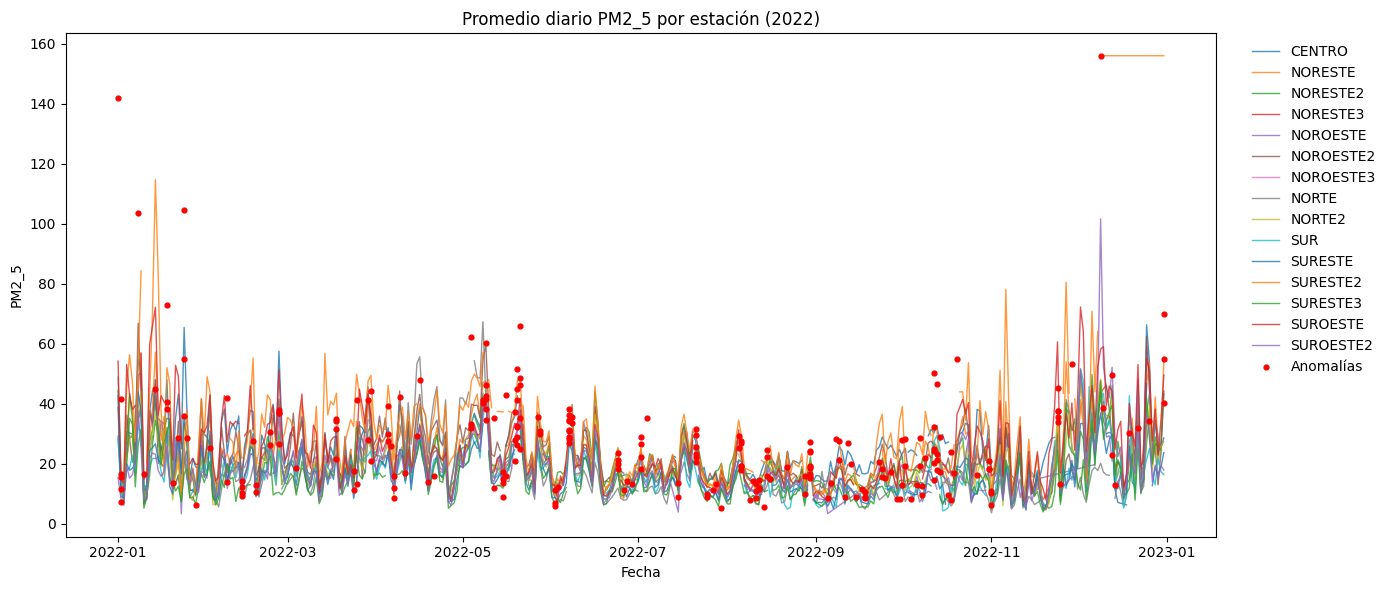

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Entradas ---
# df = pd.read_csv("sima_2022_final.csv", parse_dates=["date"])  # si no lo tienes ya
VAR = "pm2_5"   # cambia a la variable que quieras validar
YEAR = 2022

# --- 1) Promedio diario correcto por estación ---
df_yr = df[df["year"]==YEAR].copy()
df_yr["date_d"] = df_yr["date"].dt.normalize()  # fecha sin hora
df_daily = (df_yr
            .groupby(["estacion","date_d"], as_index=False)[VAR]
            .mean())

# Orden y duplicados
df_daily = df_daily.drop_duplicates(subset=["estacion","date_d"]).sort_values(["estacion","date_d"])

# --- 2) Detección de anomalías por estación ---
def detect_anomalies(sta_df, var, win=7, z_thresh=3.0, mad_k=3.5, jump_abs=60):
    g = sta_df.copy().sort_values("date_d")
    s = g[var].astype(float)

    # z-score sobre media móvil (ventana=7)
    mu = s.rolling(win, min_periods=3, center=True).mean()
    sd = s.rolling(win, min_periods=3, center=True).std(ddof=0)
    z = (s - mu) / sd
    flag_z = z.abs() > z_thresh

    # MAD robusto
    med = s.rolling(win, min_periods=3, center=True).median()
    mad = (s - med).abs().rolling(win, min_periods=3, center=True).median()
    z_mad = 0.6745 * (s - med) / (mad.replace(0, np.nan))
    flag_mad = z_mad.abs() > mad_k

    # Saltos absolutos entre días consecutivos
    diff = s.diff().abs()
    flag_jump = diff > jump_abs

    # Combinar
    g["anomaly"] = (flag_z.fillna(False) | flag_mad.fillna(False) | flag_jump.fillna(False))
    g["z_score"] = z
    g["z_mad"]  = z_mad
    g["jump"]   = diff

    return g

out_list = []
for est, g in df_daily.groupby("estacion"):
    out_list.append(detect_anomalies(g, VAR, win=7, z_thresh=3.0, mad_k=3.5, jump_abs=60))
df_daily_flagged = pd.concat(out_list, ignore_index=True)

# --- 3) (Opcional) Excluir anomalías del trazo principal ---
EXCLUIR_ANOMALIAS_EN_TRAZO = True
plot_df = df_daily_flagged.copy()
if EXCLUIR_ANOMALIAS_EN_TRAZO:
    plot_df["yplot"] = np.where(plot_df["anomaly"], np.nan, plot_df[VAR])
else:
    plot_df["yplot"] = plot_df[VAR]

# --- 4) Reporte rápido de anómalas (para que veas si NORESTE trae algo raro) ---
rep = (df_daily_flagged[df_daily_flagged["anomaly"]]
       .groupby("estacion")["anomaly"].count()
       .sort_values(ascending=False))
print("Anomalías detectadas por estación (conteo):")
print(rep.head(10))

# --- 5) Gráfico robusto ---
plt.figure(figsize=(14,6))
for est, g in plot_df.groupby("estacion"):
    g = g.sort_values("date_d")
    plt.plot(g["date_d"], g["yplot"], label=est, alpha=0.8, linewidth=1)

# Pintar puntos rojos en anómalas
anom = df_daily_flagged[df_daily_flagged["anomaly"]]
plt.scatter(anom["date_d"], anom[VAR], s=12, c="red", label="Anomalías", zorder=5)

plt.title(f"Promedio diario {VAR.upper()} por estación ({YEAR})")
plt.xlabel("Fecha"); plt.ylabel(f"{VAR.upper()}")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", ncol=1, frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
df_clean = df_daily_flagged.copy()
df_clean.loc[df_clean["anomaly"], VAR] = np.nan


In [ ]:
# === REMOVER OUTLIERS DIARIOS EN PM2.5 (por estación) ===
# Entrada  : sima_2022_final.csv  (dataset horario ya limpio/imputado)
# Salidas  : sima_2022_outliers_log_pm25.csv (log de días anómalos)
#            sima_2022_final_sin_outliers.csv (horario con NaN en días anómalos)
#            df_daily_clean (DataFrame en memoria con daily ya limpio)
import pandas as pd
import numpy as np
from pathlib import Path

VAR  = "pm2_5"
YEAR = 2022
IN_HOURLY  = "sima_2022_final.csv"
OUT_HOURLY = "sima_2022_final_sin_outliers.csv"
OUT_LOG    = "sima_2022_outliers_log_pm25.csv"

# ----------------------------------------------------------
# 1) Cargar dataset horario
# ----------------------------------------------------------
df = pd.read_csv(IN_HOURLY, parse_dates=["date"])
if "year" not in df.columns:
    df["year"] = df["date"].dt.year
if "estacion" not in df.columns:
    raise RuntimeError("No encontré columna 'estacion' en el CSV.")

df = df[df["year"] == YEAR].copy()
df["date_d"] = df["date"].dt.normalize()  # fecha sin hora

# ----------------------------------------------------------
# 2) Daily por estación y detección de anomalías
# ----------------------------------------------------------
df_daily = (df.groupby(["estacion","date_d"], as_index=False)[VAR]
              .mean()
              .drop_duplicates(subset=["estacion","date_d"])
              .sort_values(["estacion","date_d"]))

def detect_anomalies(sta_df, var, win=7, z_thresh=3.0, mad_k=3.5, jump_abs=60):
    g = sta_df.copy().sort_values("date_d")
    s = g[var].astype(float)

    # z-score respecto a media móvil
    mu = s.rolling(win, min_periods=3, center=True).mean()
    sd = s.rolling(win, min_periods=3, center=True).std(ddof=0)
    z = (s - mu) / sd

    # z-MAD robusto
    med = s.rolling(win, min_periods=3, center=True).median()
    mad = (s - med).abs().rolling(win, min_periods=3, center=True).median()
    z_mad = 0.6745 * (s - med) / (mad.replace(0, np.nan))

    # salto absoluto día a día
    jump = s.diff().abs()

    g["anomaly"]  = (z.abs() > z_thresh) | (z_mad.abs() > mad_k) | (jump > jump_abs)
    g["z_score"]  = z
    g["z_mad"]    = z_mad
    g["jump_abs"] = jump
    return g

df_flagged = pd.concat(
    [detect_anomalies(g, VAR) for _, g in df_daily.groupby("estacion")],
    ignore_index=True
)

# ----------------------------------------------------------
# 3) Guardar LOG de anomalías (diario)
# ----------------------------------------------------------
anom = (df_flagged[df_flagged["anomaly"]]
        .sort_values(["estacion","date_d"])
        .rename(columns={"date_d":"date"}))
anom["variable"] = VAR
anom[["estacion","date",VAR,"z_score","z_mad","jump_abs","variable"]].to_csv(OUT_LOG, index=False)

print(f"Anomalías detectadas: {len(anom)}  -> Log: {Path(OUT_LOG).resolve()}")

# ----------------------------------------------------------
# 4) Invalidar en el nivel horario TODAS las horas del día anómalo
# ----------------------------------------------------------
# set de claves (estación, fecha) a invalidar
keys = set(zip(anom["estacion"], pd.to_datetime(anom["date"]).dt.normalize()))
# marcar filas horarias afectadas
mask = df.apply(lambda r: (r["estacion"], r["date_d"]) in keys, axis=1)
n_afectadas = int(mask.sum())

# invalidar
df.loc[mask, VAR] = np.nan

# limpiar columna auxiliar y guardar CSV horario sin outliers
df_out = df.drop(columns=["date_d"]).sort_values(["estacion","date"])
df_out.to_csv(OUT_HOURLY, index=False)
print(f"Filas horarias invalidadas en {VAR}: {n_afectadas:,}")
print(f"CSV horario sin outliers: {Path(OUT_HOURLY).resolve()}")

# ----------------------------------------------------------
# 5) Recalcular daily limpio (útil para graficar)
# ----------------------------------------------------------
df_out["date_d"] = pd.to_datetime(df_out["date"]).dt.normalize()
df_daily_clean = (df_out.groupby(["estacion","date_d"], as_index=False)[VAR]
                        .mean()
                        .sort_values(["estacion","date_d"]))

print("Daily limpio (primeras filas):")
print(df_daily_clean.head())


Anomalías detectadas: 245  -> Log: /content/sima_2022_outliers_log_pm25.csv
Filas horarias invalidadas en pm2_5: 5,880
CSV horario sin outliers: /content/sima_2022_final_sin_outliers.csv
Daily limpio (primeras filas):
  estacion     date_d      pm2_5
0   CENTRO 2022-01-01  29.173750
1   CENTRO 2022-01-02  11.750000
2   CENTRO 2022-01-03   7.232083
3   CENTRO 2022-01-04  30.655417
4   CENTRO 2022-01-05  30.267500


Filas horarias SURESTE2 en dic-2022: 721
NaN por variable (dic-2022):
pm2_5    0.033
pm10     0.000
o3       0.000
no2      0.000
rh       0.000
tout     0.000
wsr      0.000
dtype: float64


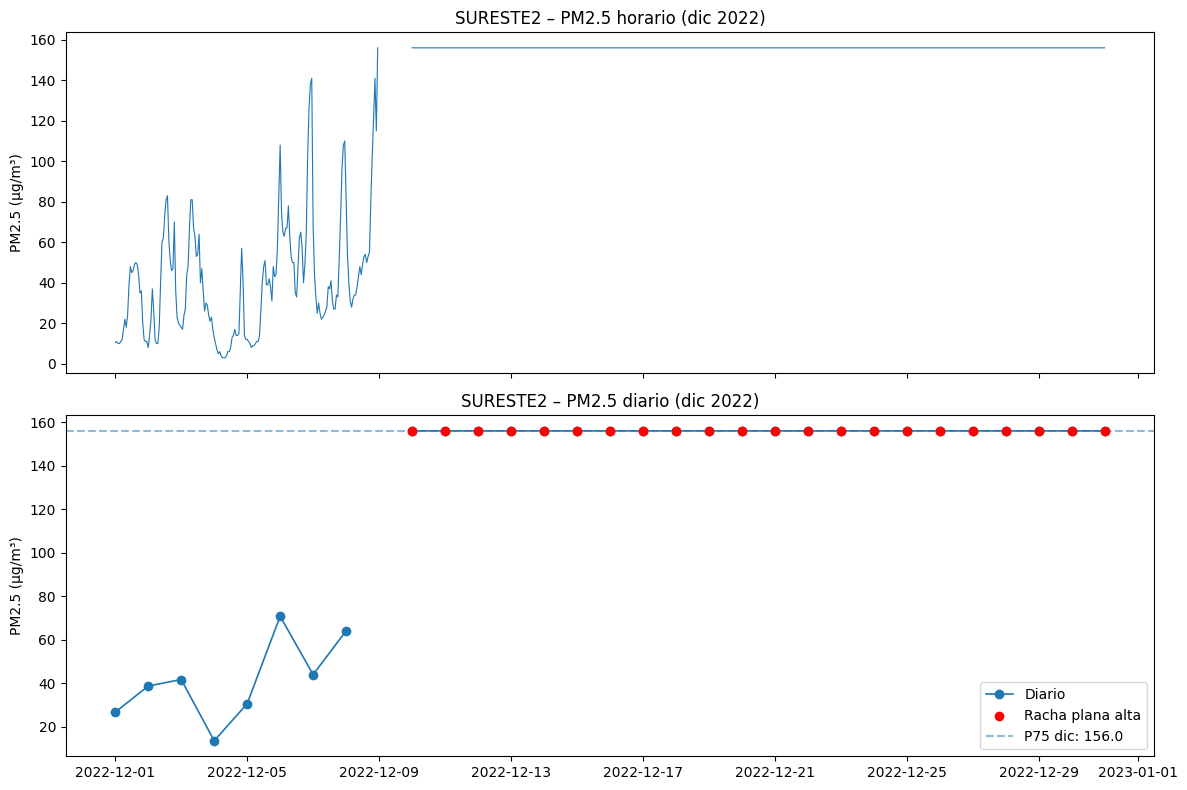

Días marcados como racha plana alta (si la tabla sale vacía, no hubo bloque):
         date  pm2_5  pm2_5_rolling_std3  pm2_5_rolling_mean3
9  2022-12-10  156.0                 0.0                156.0
10 2022-12-11  156.0                 0.0                156.0
11 2022-12-12  156.0                 0.0                156.0
12 2022-12-13  156.0                 0.0                156.0
13 2022-12-14  156.0                 0.0                156.0
14 2022-12-15  156.0                 0.0                156.0
15 2022-12-16  156.0                 0.0                156.0
16 2022-12-17  156.0                 0.0                156.0
17 2022-12-18  156.0                 0.0                156.0
18 2022-12-19  156.0                 0.0                156.0
19 2022-12-20  156.0                 0.0                156.0
20 2022-12-21  156.0                 0.0                156.0
21 2022-12-22  156.0                 0.0                156.0
22 2022-12-23  156.0                 0.0              

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV = "sima_2022_final_sin_outliers.csv"
EST = "SURESTE2"
INI = "2022-12-01"
FIN = "2022-12-31"

# 1) Cargar y filtrar
dfh = pd.read_csv(CSV, parse_dates=["date"])
dfh = dfh[(dfh["estacion"]==EST) & (dfh["date"].between(INI, FIN))].copy()
dfh["date_d"] = dfh["date"].dt.normalize()

print(f"Filas horarias {EST} en dic-2022:", len(dfh))
print("NaN por variable (dic-2022):")
print(dfh[["pm2_5","pm10","o3","no2","rh","tout","wsr"]].isna().mean().round(3))

# 2) Promedio diario y series
dfd = (dfh.groupby("date_d", as_index=False)["pm2_5"].mean()
         .sort_values("date_d"))
dfd["pm2_5_rolling_std3"] = dfd["pm2_5"].rolling(3, min_periods=2, center=True).std()
dfd["pm2_5_rolling_mean3"] = dfd["pm2_5"].rolling(3, min_periods=2, center=True).mean()

# 3) Heurística de “bloque plano alto”
#    - varianza móvil baja (std < 2 µg/m3)
#    - nivel alto (por encima del p75 mensual de esa estación)
thr_std = 2.0
p75 = dfd["pm2_5"].quantile(0.75)
dfd["flat_high"] = (dfd["pm2_5_rolling_std3"] < thr_std) & (dfd["pm2_5_rolling_mean3"] >= p75)

# 4) Gráficas
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

# Horario
ax[0].plot(dfh["date"], dfh["pm2_5"], linewidth=0.8)
ax[0].set_title(f"{EST} – PM2.5 horario (dic 2022)")
ax[0].set_ylabel("PM2.5 (µg/m³)")

# Diario + marcadores “flat_high”
ax[1].plot(dfd["date_d"], dfd["pm2_5"], marker="o", lw=1.2, label="Diario")
ax[1].scatter(dfd.loc[dfd["flat_high"], "date_d"],
              dfd.loc[dfd["flat_high"], "pm2_5"],
              color="red", zorder=5, label="Racha plana alta")
ax[1].axhline(p75, ls="--", alpha=0.5, label=f"P75 dic: {p75:.1f}")
ax[1].set_title(f"{EST} – PM2.5 diario (dic 2022)")
ax[1].set_ylabel("PM2.5 (µg/m³)")
ax[1].legend()
plt.tight_layout()
plt.show()

# 5) Tabla de días sospechosos
sospechosos = dfd.loc[dfd["flat_high"], ["date_d","pm2_5","pm2_5_rolling_std3","pm2_5_rolling_mean3"]]
sospechosos = sospechosos.rename(columns={"date_d":"date"})
print("Días marcados como racha plana alta (si la tabla sale vacía, no hubo bloque):")
print(sospechosos)

# 6) (Opcional) Verificación de constancia horaria en días sospechosos
if not sospechosos.empty:
    dias = sospechosos["date"].dt.normalize().unique()
    chk = (dfh[dfh["date_d"].isin(dias)]
           .groupby("date_d")["pm2_5"].agg(n="count", min="min", max="max", std="std"))
    print("\nChequeo horario en días sospechosos (min, max, std):")
    print(chk)


In [ ]:
import pandas as pd

# Carga el dataset con imputación previa (el que ya tienes)
df = pd.read_csv("sima_2022_final_sin_outliers.csv", parse_dates=["date"])

# --- 1) Definir rango del bloque plano anómalo ---
estacion_err = "SURESTE2"
inicio = "2022-12-10"
fin    = "2022-12-31"

# --- 2) Filtrar las filas que NO pertenecen al bloque ---
mask_err = (df["estacion"] == estacion_err) & (df["date"].between(inicio, fin))
print("Filas a eliminar:", mask_err.sum())

df_clean = df.loc[~mask_err].copy()

# --- 3) Guardar dataset limpio ---
df_clean.to_csv("sima_2022_final_sin_outliers_v2.csv", index=False)
print("Archivo limpio guardado como: sima_2022_final_sin_outliers_v2.csv")

# --- 4) (Opcional) Checar que ya no exista el bloque plano ---
check = df_clean[(df_clean["estacion"] == estacion_err) & (df_clean["date"].dt.month == 12)]
print(check.groupby(check["date"].dt.date)["pm2_5"].describe().head())


Filas a eliminar: 505
Archivo limpio guardado como: sima_2022_final_sin_outliers_v2.csv
            count       mean        std   min    25%   50%    75%   max
date                                                                   
2022-12-01   24.0  26.687500  15.862050  10.0  11.00  21.0  44.25  50.0
2022-12-02   24.0  38.708333  24.184938   8.0  18.75  36.5  60.25  83.0
2022-12-03   24.0  41.708333  20.488553  17.0  24.00  38.0  56.25  81.0
2022-12-04   24.0  13.541667  13.204015   3.0   5.75  11.0  14.00  57.0
2022-12-05   24.0  30.583333  19.986771   8.0  11.00  34.5  43.25  82.0
